In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

In [2]:
from sklearn import datasets
digits = datasets.load_digits()
list(digits.keys())

['data', 'target', 'target_names', 'images', 'DESCR']

In [3]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [4]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [5]:
y.shape

(1797,)

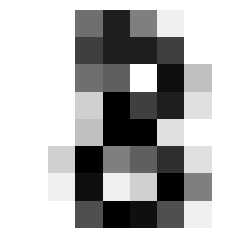

In [6]:
some_digit = X[8]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[8]

8

Intuitively, the digits are unlikely to be linearly separable just by the individual pixel values; as basically all digits (with the exception of 0) are concentrated around the centre, with less densely coloured peripheries.
As such, the kernel trick will likely have to be performed to get the classifiers to achieve good performance. 

As our first steps, we shall split the data into training and test sets as before, and do basic evaluation for some classifiers on the test set to get a feeling for the "baseline".

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


In [9]:
def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(digits["target"]),
    "Stratified tr": subset_proportions(y_train),
    "Stratified ts": subset_proportions(y_test),
})
compare_props["Strat. tr %error"] = 100 * compare_props["Stratified tr"] / compare_props["Overall"] - 100
compare_props["Strat. ts %error"] = 100 * compare_props["Stratified ts"] / compare_props["Overall"] - 100

compare_props.sort_index()

,Overall,Stratified tr,Stratified ts,Strat. tr %error,Strat. ts %error
0,0.099054,0.098817,0.100000,-0.239263,0.955056
1,0.101280,0.101601,0.100000,0.316594,-1.263736
2,0.098497,0.098817,0.097222,0.324357,-1.294727
3,0.101836,0.101601,0.102778,-0.231584,0.924408
4,0.100723,0.100905,0.100000,0.179933,-0.718232
5,0.101280,0.100905,0.102778,-0.370506,1.478938
6,0.100723,0.100905,0.100000,0.179933,-0.718232
7,0.099610,0.099513,0.100000,-0.097969,0.391061
8,0.096828,0.096729,0.097222,-0.101984,0.407088
9,0.100167,0.100209,0.100000,0.041754,-0.166667


We can see that the stratification works less perfectly for a larger number of classes, but this perhaps was to be expected---especially for the fairly small size test set.

Regardless, consider now some very basic classification efforts:

In [10]:
from sklearn.linear_model import SGDClassifier            # Perceptron classifier for binary class detection.
from sklearn.linear_model import LogisticRegression       # Logistic Regressor; also typically for binary classification
from sklearn.naive_bayes import GaussianNB, MultinomialNB # Naïve Bayes classifiers from the practical.
from sklearn.tree import DecisionTreeClassifier           # Decision Tree that did notoccur in the practical
from sklearn.ensemble import RandomForestClassifier       # Also not in practical. (probs in practical 3 tho)
from sklearn.tree import ExtraTreeClassifier              # Weird randomised tree classifier, why not try it here? 

### Binary classification
Let us first try to get a baseline for binary classification to see how well the classifiers might do for this simpler task: We'll try to distinguish digits of class 0 from the other classes.

In [11]:
zero_features = X[8]
zero_label = y[8]

y_train_zero = (y_train == 8)
y_test_zero = (y_test == 8)

sgd = SGDClassifier(max_iter=8, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
log_reg = LogisticRegression()
gnb = GaussianNB()
mnb = MultinomialNB()
dte = DecisionTreeClassifier(criterion='entropy')       # Make this behave like HUffmann trees from InfoTheory
dtg = DecisionTreeClassifier(criterion='gini')
rfe = RandomForestClassifier(criterion='entropy')
rfg = RandomForestClassifier(criterion='gini')
ext = ExtraTreeClassifier()

models_ = [sgd, log_reg, gnb, mnb, dte, dtg, rfe, rfg, ext]
modellabels = {sgd: 'Perceptron', 
               log_reg: 'Logistic Regressor',
               gnb: 'Gaussian NB',
               mnb: 'Multinomial NB',
               dte: 'Decision Tree (Entropy)',
               dtg: 'Decision Tree (Gini)',
               rfe: 'Random Forest (Entropy)',
               rfg: 'Random Forest (Gini)',
               ext: 'Extra Decision Tree'
              }
for model_ in models_:
    model_.fit(X_train, y_train_zero)

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Let's see if these work on our chosen example before we go any further:

In [12]:
for model_ in models_:
    print(model_, '\n',model_.predict([zero_features]), '\n\n')

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='perceptron',
              max_iter=8, n_iter_no_change=5, n_jobs=None, penalty=None,
              power_t=0.5, random_state=42, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False) 
 [ True] 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
 [ True] 


GaussianNB(priors=None, var_smoothing=1e-09) 
 [ True] 


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 
 [ True] 


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                  

Hooray, they all manage this one simple task. Let's see how they fare for our test set overall:

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
for model_ in models_:
    print(model_, '\n')
    y_train_pred = cross_val_predict(model_, X_train, y_train_zero, cv=5)
    cm = confusion_matrix(y_train_zero, y_train_pred)
    print(list(cm[0,:]))
    print(list(cm[1,:]))
    p = precision_score(y_train_zero, y_train_pred)
    r = recall_score(y_train_zero, y_train_pred)
    f1 = f1_score(y_train_zero, y_train_pred)
    print('Precision: {}'.format(str(p)))
    print('Recall:    {}'.format(str(r)))
    print('F1-Score:  {}'.format(str(f1)))
    print('\n\n')

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='perceptron',
              max_iter=8, n_iter_no_change=5, n_jobs=None, penalty=None,
              power_t=0.5, random_state=42, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False) 

[1274, 24]
[66, 73]
Precision: 0.7525773195876289
Recall:    0.5251798561151079
F1-Score:  0.6186440677966102



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 



/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

[1266, 32]
[36, 103]
Precision: 0.762962962962963
Recall:    0.7410071942446043
F1-Score:  0.751824817518248



GaussianNB(priors=None, var_smoothing=1e-09) 

[606, 692]
[1, 138]
Precision: 0.16626506024096385
Recall:    0.9928057553956835
F1-Score:  0.28482972136222906



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

[1075, 223]
[19, 120]
Precision: 0.3498542274052478
Recall:    0.8633093525179856
F1-Score:  0.4979253112033194



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') 

[1269, 29]
[35, 104]
Precision: 0.7819548872180451
Recall:    0.7482014388489209
F1-Score:  0.7647058823529411



DecisionTreeClassifier(cla

In general, we can see that the logistic regressor actually seems to perform best, on all the metric, with only one misclassification on this particular data set. 

What is interesting to see is that most classifiers have similar numbers of false negatives as false positives, but the naive bayes classifiers make much more (numerically) false positive mistakes than false negatives, whereas the random forest is skewed towards false negatives. Indeed, consider the following:

In [15]:
for model_ in models_:
    print(model_, '\n')
    y_train_pred = cross_val_predict(model_, X_train, y_train_zero, cv=5)
    cm = confusion_matrix(y_train_zero, y_train_pred)
    print(list(cm[0,:]))
    print(list(cm[1,:]))
    fnr = cm[1,0]/(cm[1, :].sum())
    fpr = cm[0,1]/(cm[0, :].sum())
    err = fnr / fpr
    print('False Positive Rate:', fpr)
    print('False Negative Rate:', fnr)
    print('Rate of false negatives relative to rate of false positives:', err)
    print('\n\n')

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='perceptron',
              max_iter=8, n_iter_no_change=5, n_jobs=None, penalty=None,
              power_t=0.5, random_state=42, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False) 

[1274, 24]
[66, 73]
False Positive Rate: 0.01848998459167951
False Negative Rate: 0.4748201438848921
Rate of false negatives relative to rate of false positives: 25.67985611510791



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 



/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

[1266, 32]
[36, 103]
False Positive Rate: 0.02465331278890601
False Negative Rate: 0.2589928057553957
Rate of false negatives relative to rate of false positives: 10.505395683453237



GaussianNB(priors=None, var_smoothing=1e-09) 

[606, 692]
[1, 138]
False Positive Rate: 0.5331278890600925
False Negative Rate: 0.007194244604316547
Rate of false negatives relative to rate of false positives: 0.013494406786709361



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

[1075, 223]
[19, 120]
False Positive Rate: 0.17180277349768874
False Negative Rate: 0.1366906474820144
Rate of false negatives relative to rate of false positives: 0.7956253831015906



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


This shows how each of the classifiers except for the naive bayes classifiers is much more likely (in relative terms) to miscalssify what is actually an 8 than to misclassify something else! 

Let us also explore the precision/recall tradeoff for varying degrees of classifier conservativeness:

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

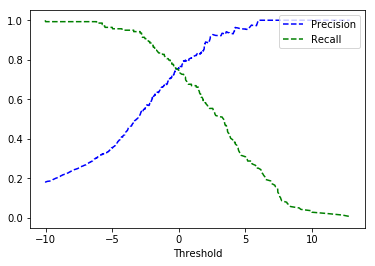

In [16]:
from sklearn.metrics import precision_recall_curve

y_scores = lambda model_, method_ : cross_val_predict(model_, 
                                             X_train, 
                                             y_train_zero, 
                                             cv=5, 
                                             method=method_)

precisions, recalls, thresholds = precision_recall_curve(y_train_zero, y_scores(log_reg, 'decision_function'))

def plot_pr_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([-0.05, 1.05])

plot_pr_vs_threshold(precisions, recalls, thresholds)
plt.show()

These findings show quite variable behaviour across the classifiers, which usually exhibit a clear 'trade-off' nature between precision and recall, as may have been expected. 

Let us also plot the ROC curves for each of these classifiers, to have some numerical quantification of how well they perform against one another.

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

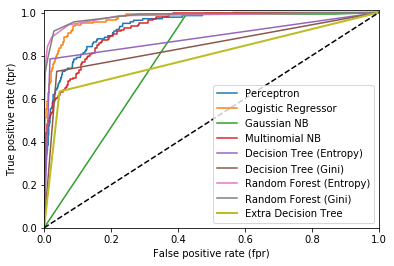

In [17]:
get_f = lambda model_ : 'decision_function' if model_ in [sgd, log_reg] else 'predict_proba'
yscores = {model_: y_scores(model_, get_f(model_)) for model_ in models_}
yscores_num = {model_: yscores[model_][:,1] if get_f(model_)=='predict_proba' else yscores[model_] for model_ in models_}

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    #plt.yscale('log')

for model_ in models_[:-1]:
    fpr, tpr, thresholds = roc_curve(y_train_zero, yscores_num[model_])
    plt.plot(fpr, tpr, label=modellabels[model_])

fpr_last, tpr_last, threshlast = roc_curve(y_train_zero, yscores_num[models_[-1]])
plot_roc_curve(fpr_last, tpr_last, modellabels[models_[-1]])
plt.legend(loc='lower right')
plt.show() 

Oof, that's ugly... it's probably better to give the area under each curve:

In [18]:
auc_scores = [(modellabels[model_], roc_auc_score(y_train_zero, yscores_num[model_])) for model_ in models_]
auc_scores.sort(key= lambda p: -p[1])

In [19]:
for p in auc_scores:
    print(p[0], p[1])

Random Forest (Gini) 0.982848543969139
Random Forest (Entropy) 0.9800550930596048
Logistic Regressor 0.9725920342308587
Perceptron 0.9388156654953387
Multinomial NB 0.9320315704293268
Decision Tree (Entropy) 0.8832265466517387
Decision Tree (Gini) 0.8444341599139794
Extra Decision Tree 0.7934342818503287
Gaussian NB 0.7821828823535932


It should be noted that by rerunning the above three cells, we can observe a slight variability in the results. In general, it seems that the random forest and logistic regression classifiers are the most performant at classifying the digit 8, wheras the gaussian NB classifier is significantly worse than the multinomial classifier. The perceptron is also quite performant despite its slightly more simplistic nature. 

Now, let us see whether applying the kernel trick might help us improve on this performance, and if any particular classifiers profit especially.

In [20]:
from sklearn.kernel_approximation import RBFSampler

In [21]:
rbf_features = RBFSampler(gamma=1, random_state=42)
X_train_features = rbf_features.fit_transform(X_train)

sgd_rbf = SGDClassifier(max_iter=8, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
log_reg_rbf = LogisticRegression()
gnb_rbf = GaussianNB() 
mnb_rbf = MultinomialNB()   # CAUSES EXCEPTION! Must ask why...
dte_rbf = DecisionTreeClassifier(criterion='entropy')       # Make this behave like HUffmann trees from InfoTheory
dtg_rbf = DecisionTreeClassifier(criterion='gini')
rfe_rbf = RandomForestClassifier(criterion='entropy')
rfg_rbf = RandomForestClassifier(criterion='gini')
ext_rbf = ExtraTreeClassifier()
to_remove = []
kmodellabels = {}
kernel_models = [sgd_rbf, log_reg_rbf, gnb_rbf, mnb_rbf, dte_rbf, dtg_rbf, rfe_rbf, rfg_rbf, ext_rbf]
for i,model_ in enumerate(kernel_models):
    try:
        model_.fit(X_train_features, y_train_zero)
    except Exception as e:
        print(modellabels[models_[i]], "caused exception: ", e)
        to_remove.append(model_)

for model_ in to_remove:
    kernel_models.remove(model_)
for i, model_ in enumerate(kernel_models):
    kmodellabels[model_] = modellabels[models_[i]] + " fit to kernelled data."
    print(kmodellabels[model_])

Multinomial NB caused exception:  Input X must be non-negative


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Perceptron fit to kernelled data.
Logistic Regressor fit to kernelled data.
Gaussian NB fit to kernelled data.
Multinomial NB fit to kernelled data.
Decision Tree (Entropy) fit to kernelled data.
Decision Tree (Gini) fit to kernelled data.
Random Forest (Entropy) fit to kernelled data.
Random Forest (Gini) fit to kernelled data.


In [22]:
for model_ in models_:
    print(modellabels[model_])
    y_train_pred = cross_val_predict(model_, X_train, y_train_zero, cv=5)
    precision = precision_score(y_train_zero, y_train_pred)
    recall = recall_score(y_train_zero, y_train_pred)
    f1 = f1_score(y_train_zero, y_train_pred)
    print(' P:', precision,'\n R:', recall, '\nF1:', f1, '\n'*3)
for model_ in kernel_models:
    print(kmodellabels[model_])
    y_train_pred = cross_val_predict(model_, X_train_features, y_train_zero, cv=5)
    precision = precision_score(y_train_zero, y_train_pred)
    recall = recall_score(y_train_zero, y_train_pred)
    f1 = f1_score(y_train_zero, y_train_pred)
    print(' P:', precision,'\n R:', recall, '\nF1:', f1, '\n'*3)

Perceptron
 P: 0.7525773195876289 
 R: 0.5251798561151079 
F1: 0.6186440677966102 



Logistic Regressor


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

 P: 0.762962962962963 
 R: 0.7410071942446043 
F1: 0.751824817518248 



Gaussian NB
 P: 0.16626506024096385 
 R: 0.9928057553956835 
F1: 0.28482972136222906 



Multinomial NB
 P: 0.3498542274052478 
 R: 0.8633093525179856 
F1: 0.4979253112033194 



Decision Tree (Entropy)
 P: 0.84251968503937 
 R: 0.7697841726618705 
F1: 0.8045112781954887 



Decision Tree (Gini)
 P: 0.6736111111111112 
 R: 0.697841726618705 
F1: 0.6855123674911661 



Random Forest (Entropy)
 P: 1.0 
 R: 0.7050359712230215 
F1: 0.8270042194092826 



Random Forest (Gini)
 P: 0.9743589743589743 
 R: 0.5467625899280576 
F1: 0.7004608294930875 



Extra Decision Tree
 P: 0.6115107913669064 
 R: 0.6115107913669064 
F1: 0.6115107913669064 



Perceptron fit to kernelled data.
 P: 0.0975609756097561 
 R: 0.02877697841726619 
F1: 0.04444444444444444 



Logistic Regressor fit to kernelled data.
 P: 0.0 
 R: 0.0 
F1: 0.0 



Gaussian NB fit to kernelled data.
 P: 0.0 
 R: 0.0 
F1: 0.0 



Multinomial NB fit to kernelled d

/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

 P: 0.12418300653594772 
 R: 0.1366906474820144 
F1: 0.13013698630136986 



Decision Tree (Entropy) fit to kernelled data.
 P: 0.10404624277456648 
 R: 0.12949640287769784 
F1: 0.11538461538461538 



Decision Tree (Gini) fit to kernelled data.
 P: 0.0 
 R: 0.0 
F1: 0.0 



Random Forest (Entropy) fit to kernelled data.
 P: 0.0 
 R: 0.0 
F1: 0.0 



Random Forest (Gini) fit to kernelled data.
 P: 0.12371134020618557 
 R: 0.17266187050359713 
F1: 0.14414414414414414 





OH DEAR! Performance is terrible with the kernel trick... I wonder why...

#### Anyway, let's move on to multiclass classification.

As a first step, let's try the simple perceptron on our example of an eight from before.

In [23]:
sgd.fit(X_train, y_train) # i.e., all instances, not just one class
print(sgd.predict([zero_features]))

[8]


Awesome, this works!

Let's check the others:

In [24]:
for model_ in models_:
    model_.fit(X_train, y_train)    
    print('Prediction of ', modellabels[model_]+':', model_.predict([zero_features]), '\n\n')

Prediction of  Perceptron: [8] 


Prediction of  Logistic Regressor: [8] 


Prediction of  Gaussian NB: [8] 




/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Prediction of  Multinomial NB: [8] 


Prediction of  Decision Tree (Entropy): [8] 


Prediction of  Decision Tree (Gini): [8] 


Prediction of  Random Forest (Entropy): [8] 


Prediction of  Random Forest (Gini): [8] 


Prediction of  Extra Decision Tree: [8] 




That's incredible, they all work on our chosen example!

Let's analyse how sure they were:

In [25]:
for model_ in models_:
    print(modellabels[model_])
    if(get_f(model_)=='decision_function'):
        scores = model_.decision_function( [zero_features])
    else:
        scores = model_.predict_proba([zero_features])
    print('\n'.join(map(str, enumerate(scores[0]))))
    print('Prediction: ', np.argmax(scores), '\n\n\n')

Perceptron
(0, -6094.0)
(1, -10719.0)
(2, -4563.0)
(3, -7407.0)
(4, -11434.0)
(5, -8465.0)
(6, -4267.0)
(7, -6902.0)
(8, 4712.0)
(9, -8508.0)
Prediction:  8 



Logistic Regressor
(0, -17.422089774036223)
(1, -26.280113905989094)
(2, -18.01249221269653)
(3, -18.834754385406814)
(4, -30.648274757287773)
(5, -35.80656741666351)
(6, -13.643531860043543)
(7, -23.92071023437435)
(8, 5.785136799047196)
(9, -16.595006929580915)
Prediction:  8 



Gaussian NB
(0, 0.0)
(1, 2.897898867265994e-14)
(2, 4.4977296295874355e-28)
(3, 1.272859571607606e-29)
(4, 0.0)
(5, 3.8507147370696834e-45)
(6, 0.0)
(7, 0.0)
(8, 0.9999999999999716)
(9, 7.028992771786413e-45)
Prediction:  8 



Multinomial NB
(0, 2.55827660254574e-94)
(1, 5.346582520899563e-25)
(2, 2.536858085758023e-23)
(3, 1.0099149496263645e-27)
(4, 9.294245458755066e-70)
(5, 1.0418550748150519e-54)
(6, 2.2813294674137231e-69)
(7, 1.1292889999481863e-98)
(8, 1.0)
(9, 6.475776014695776e-36)
Prediction:  8 



Decision Tree (Entropy)
(0, 0.0)
(1, 0.

OK, so they were all very sure. Let's move on to the performance across the whole data set.

In [26]:
from sklearn.model_selection import cross_val_score

for model_ in models_:
    print(modellabels[model_])
    print(np.mean(cross_val_score(model_, X_train, y_train, cv=5, scoring="accuracy")), '\n'*2)

Perceptron
0.9267995701513743 


Logistic Regressor


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

0.9519151161675566 


Gaussian NB
0.8272523770224762 


Multinomial NB
0.8976291522375159 


Decision Tree (Entropy)
0.8572182871993759 


Decision Tree (Gini)
0.855134505715793 


Random Forest (Entropy)
0.9471075349073447 


Random Forest (Gini)
0.9400265794303302 


Extra Decision Tree
0.7604566041770571 




Now let us also try and see the effect of scaling on this data set:

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler() # Can't use standard because Multinomial NB craps itself in the face of negative values...
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [28]:
for model_ in models_:
    print(modellabels[model_])
    print(np.mean(cross_val_score(model_, X_train_scaled, y_train, cv=5, scoring="accuracy")), '\n'*2)

Perceptron
0.9373480229336163 


Logistic Regressor


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

0.9554407802869573 


Gaussian NB
0.8084260008317716 


Multinomial NB
0.8990110176349825 


Decision Tree (Entropy)
0.860717885885759 


Decision Tree (Gini)
0.8544929330594837 


Random Forest (Entropy)
0.9435866279776766 


Random Forest (Gini)
0.9400775376542919 


Extra Decision Tree
0.7716644833754633 




Finally, let us try and get an overview of how much confusion there is between each of the different classes. Remember, the y-axis is the actual class, whereas the x-axis is the predicted class. 

Perceptron


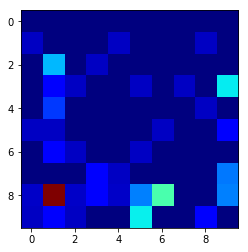

Greatest misclassification: 81 


Logistic Regressor


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Futur

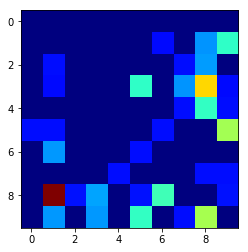

Greatest misclassification: 81 


Gaussian NB


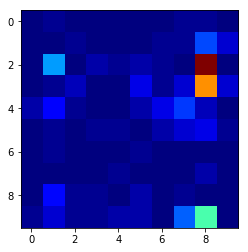

Greatest misclassification: 28 


Multinomial NB


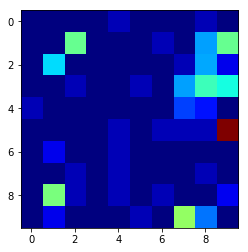

Greatest misclassification: 59 


Decision Tree (Entropy)


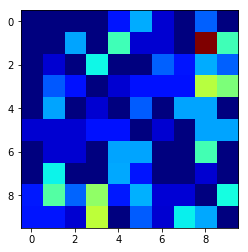

Greatest misclassification: 18 


Decision Tree (Gini)


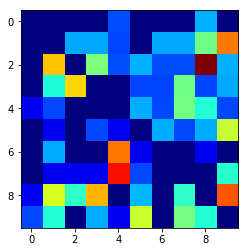

Greatest misclassification: 28 


Random Forest (Entropy)


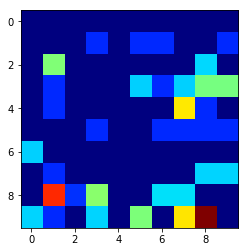

Greatest misclassification: 98 


Random Forest (Gini)


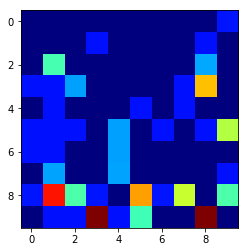

Greatest misclassification: 93 


Extra Decision Tree


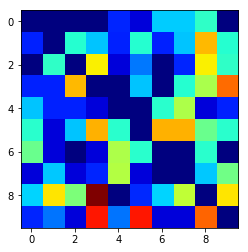

Greatest misclassification: 83 




In [29]:
for model_ in models_:
    print(modellabels[model_])
    y_train_pred = cross_val_predict(model_, X_train_scaled, y_train, cv=4)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.imshow(norm_conf_mx, cmap = "jet")
    plt.show()
    print('Greatest misclassification:', np.argmax(norm_conf_mx), '\n\n')

### Finally, let us evaluate the performance on the test set.
For this, we shall focus on the three classifiers that have performed best so far; the logistic regressor, the perceptron, and the random forest.

In [30]:
from sklearn.metrics import accuracy_score
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

for model_ in models_:
    print(modellabels[model_])
    model_.fit(X_train_scaled, y_train)
    y_pred = model_.predict(X_test_scaled)
    print('Accuracy', accuracy_score(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(' P:', precision,'\n R:', recall, '\nF1:', f1, '\n'*2)

Perceptron
Accuracy 0.9277777777777778
 P: 0.9344560984665821 
 R: 0.9277777777777778 
F1: 0.9255566606019607 


Logistic Regressor
Accuracy 0.9611111111111111
 P: 0.9612735642173205 
 R: 0.9611111111111111 
F1: 0.9609416398289637 


Gaussian NB
Accuracy 0.7861111111111111
 P: 0.8300296045586228 
 R: 0.7861111111111111 
F1: 0.7883863435862885 


Multinomial NB
Accuracy 0.8888888888888888
 P: 0.8889706112708241 
 R: 0.8888888888888888 
F1: 0.8878721753610153 


Decision Tree (Entropy)
Accuracy 0.8527777777777777
 P: 0.8575714279661649 
 R: 0.8527777777777777 
F1: 0.8536212261075039 


Decision Tree (Gini)
Accuracy 0.8138888888888889
 P: 0.8174988806926147 
 R: 0.8138888888888889 
F1: 0.8123891201308273 


Random Forest (Entropy)


/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dks28/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy 0.9444444444444444
 P: 0.9458154113532427 
 R: 0.9444444444444444 
F1: 0.9445009908732194 


Random Forest (Gini)
Accuracy 0.9388888888888889
 P: 0.9418021259399724 
 R: 0.9388888888888889 
F1: 0.9384380785803622 


Extra Decision Tree
Accuracy 0.7416666666666667
 P: 0.7487639836964595 
 R: 0.7416666666666667 
F1: 0.740901889645263 


